# 🧾 Business Documents — RAG Data Preparation & Text Embedding Pipeline
This notebook analyzes and processes unstructured text data (emails, reports, notes) to build retrieval-augmented generation (RAG) context datasets.

In [1]:
# STEP 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer
import faiss
import torch
sns.set(style='whitegrid')
nltk.download('punkt')
nltk.download('stopwords')


C:\Users\akasar\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\akasar\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\akasar\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/fram

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\akasar\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akasar\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [3]:
# STEP 2: Load dataset
df = pd.read_csv('D:/Desktop/GenAI-Powered Analytics Platform/Data/raw/business_documents_rag.csv', parse_dates=['created_date'])
print('Shape:', df.shape)
df.head()


Shape: (1500, 10)


,doc_id,title,author,created_date,doc_type,related_department,summary,content,keywords,embedding_id
0,DOC-2022-01847,Q1 2022 Sales Performance and Pipeline Analysis,Finance Department,2022-04-07,Quarterly Report,Sales,"This report reviews Q1 2022 sales results, pip...",Executive Summary: In Q1 2022 (ended March 31)...,"sales performance, pipeline, revenue, regional...",EMB-46120
1,DOC-2023-20439,Marketing-HR Coordination Meeting Notes: Q3 Ev...,Sarah Johnson,2023-07-18,Meeting Note,Marketing,"Notes from the July 18, 2023 coordination meet...",Meeting Title: Marketing-HR Coordination on Q3...,"event staffing, budget, training, HR coordinat...",EMB-77254
2,DOC-2024-31072,Email: Q4 Pricing Update and Customer Notifica...,David Nguyen,2024-10-03,Email,Sales,Email to Sales and Customer Success outlining ...,Subject: Q4 Pricing Update and Customer Notifi...,"pricing update, customer communication, CPQ, d...",EMB-11839
3,DOC-2025-50966,IT Remote Access and MFA Policy,IT Security Office,2025-02-12,Policy,IT,"Defines requirements for secure remote access,...",Purpose: To protect company systems and data b...,"remote access, MFA, security policy, device co...",EMB-64051
4,DOC-2023-41205,Executive Summary: Customer Churn Analysis H1 ...,Alexis Turner,2023-08-02,Summary,Finance,An executive-level summary of H1 2023 churn dr...,"Background: During H1 2023, gross churn reache...","churn analysis, NRR, support response, pricing...",EMB-22763


Document types:
 doc_type
Email               346
Quarterly Report    314
Policy              297
Meeting Note        290
Summary             253
Name: count, dtype: int64

Departments:
 related_department
IT           376
Finance      334
Sales        316
Marketing    256
HR           218
Name: count, dtype: int64


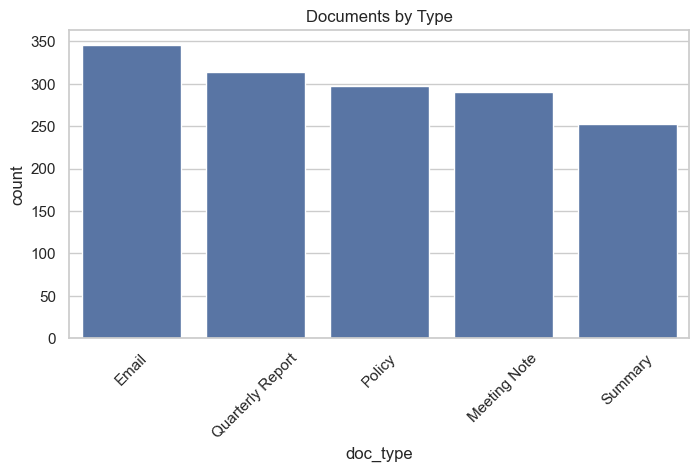

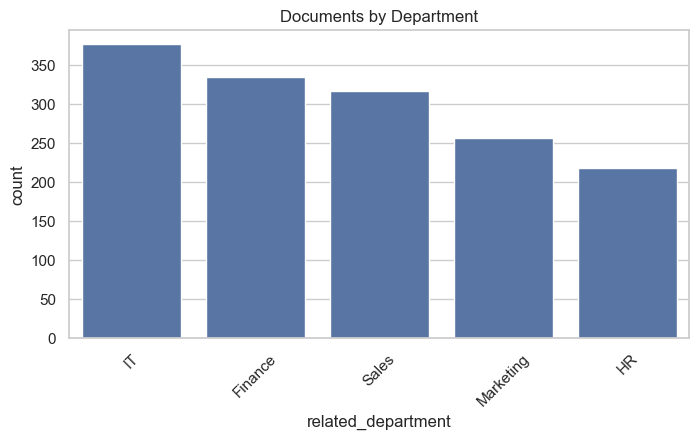

In [4]:
# STEP 3: EDA on metadata
print('Document types:\n', df['doc_type'].value_counts())
print('\nDepartments:\n', df['related_department'].value_counts())

plt.figure(figsize=(8,4))
sns.countplot(x='doc_type', data=df, order=df['doc_type'].value_counts().index)
plt.title('Documents by Type')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(x='related_department', data=df, order=df['related_department'].value_counts().index)
plt.title('Documents by Department')
plt.xticks(rotation=45)
plt.show()


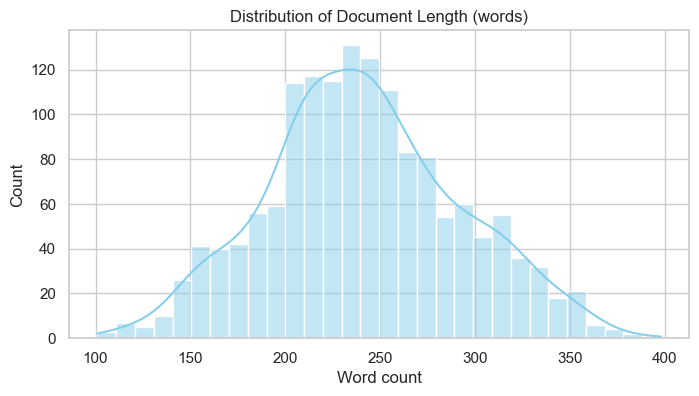

In [5]:
# STEP 4: Text length analysis
df['content_length'] = df['content'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8,4))
sns.histplot(df['content_length'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Document Length (words)')
plt.xlabel('Word count')
plt.show()


In [10]:
import nltk

# Download both required models
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\akasar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\akasar\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akasar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# STEP 5: Text preprocessing
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r'[^a-zA-Z ]', '', str(text))
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return ' '.join(tokens)

df['clean_content'] = df['content'].apply(clean_text)
df[['content','clean_content']].head()


,content,clean_content
0,Executive Summary: In Q1 2022 (ended March 31)...,executive summary ended march total revenue re...
1,Meeting Title: Marketing-HR Coordination on Q3...,meeting title marketinghr coordination event s...
2,Subject: Q4 Pricing Update and Customer Notifi...,subject pricing update customer notification p...
3,Purpose: To protect company systems and data b...,purpose protect company systems data ensuring ...
4,"Background: During H1 2023, gross churn reache...",background gross churn reached net revenue ret...


In [12]:
# STEP 6: Embedding generation
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['clean_content'].tolist(), show_progress_bar=True)
embeddings = np.array(embeddings).astype('float32')

# Save embeddings dimension for FAISS
d = embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(embeddings)
print('FAISS index built:', index.ntotal, 'vectors')


Batches:   0%|          | 0/47 [00:00<?, ?it/s]

FAISS index built: 1500 vectors


In [13]:
# STEP 7: Simple RAG-style retrieval simulation
def semantic_search(query, top_k=5):
    query_emb = model.encode([query]).astype('float32')
    D, I = index.search(query_emb, top_k)
    return df.iloc[I[0]][['doc_id','title','doc_type','related_department','summary']]

# Example
query = 'quarterly revenue performance meeting summary'
results = semantic_search(query, top_k=3)
results


,doc_id,title,doc_type,related_department,summary
1432,DOC-2025-84402,Q4 2024 Finance Close and Year-End Highlights,Quarterly Report,Finance,"Provides Q4 2024 close results, year-end finan..."
1155,DOC-2022-78041,Q3 2022 Financial Performance and Forecast Update,Quarterly Report,Finance,"Report detailing Q3 2022 revenue, expenses, ca..."
1297,DOC-2024-11709,Email: Notice of Q1 2024 Forecast Adjustment,Email,Finance,Finance informs leadership of a downward reven...


In [14]:
# STEP 8: Save vector index and processed data
faiss.write_index(index, 'business_docs_index.faiss')
df.to_csv('business_documents_processed.csv', index=False)
print('Saved processed text and FAISS index.')


Saved processed text and FAISS index.


## ✅ Next Steps
- Integrate `business_docs_index.faiss` into your RAG backend (LangChain, LlamaIndex, or Haystack).
- Use `summary` + `keywords` fields for improved retrieval metadata filtering.
- Fine-tune retrieval scoring with hybrid search (BM25 + embeddings).
